In [1]:
%matplotlib inline

import gym
from gym.wrappers import Monitor
import itertools
import numpy as np
import os
import random
import sys
import psutil
import tensorflow as tf

from reinforcementlearning.lib import plotting
from collections import deque, namedtuple

In [2]:
env = gym.envs.make("MountainCar-v0")

In [3]:
env.action_space

Discrete(3)

In [4]:
VALID_ACTIONS = [0, 1, 2]

In [5]:
env.observation_space

Box(2,)

In [6]:
class StateProcessor():
    def __init__(self):
        # Build the Tensorflow graph
        with tf.variable_scope("state_processor"):
            self.input_state = tf.placeholder(shape=[2], dtype=tf.uint8)
            self.output = self.input_state

    def process(self, sess, state):
        return sess.run(self.output, { self.input_state: state })

In [7]:
class Estimator():
    """Q-Value Estimator neural network.

    This network is used for both the Q-Network and the Target Network.
    """

    def __init__(self, scope="estimator", summaries_dir=None):
        self.scope = scope
        # Writes Tensorboard summaries to disk
        self.summary_writer = None
        with tf.variable_scope(scope):
            # Build the graph
            self._build_model()
            if summaries_dir:
                summary_dir = os.path.join(summaries_dir, "summaries_{}".format(scope))
                if not os.path.exists(summary_dir):
                    os.makedirs(summary_dir)
                self.summary_writer = tf.summary.FileWriter(summary_dir)

    def _build_model(self):
        """
        Builds the Tensorflow graph.
        """

        # Placeholders for our input
        # Our input are 4 grayscale frames of shape 84, 84 each
        self.X_pl = tf.placeholder(shape=[None, 2], dtype=tf.float32, name="X")
        # The TD target value
        self.y_pl = tf.placeholder(shape=[None], dtype=tf.float32, name="y")
        # Integer id of which action was selected
        self.actions_pl = tf.placeholder(shape=[None], dtype=tf.int32, name="actions")

        batch_size = tf.shape(self.X_pl)[0]

        # Fully connected layers
        fc1 = tf.contrib.layers.fully_connected(self.X_pl, 16)
        self.predictions = tf.contrib.layers.fully_connected(fc1, len(VALID_ACTIONS))

        # Get the predictions for the chosen actions only
        gather_indices = tf.range(batch_size) * tf.shape(self.predictions)[1] + self.actions_pl
        self.action_predictions = tf.gather(tf.reshape(self.predictions, [-1]), gather_indices)

        # Calculate the loss
        self.losses = tf.squared_difference(self.y_pl, self.action_predictions)
        self.loss = tf.reduce_mean(self.losses)

        # Optimizer Parameters from original paper
        self.optimizer = tf.train.RMSPropOptimizer(0.00025, 0.99, 0.0, 1e-6)
        self.train_op = self.optimizer.minimize(self.loss, global_step=tf.contrib.framework.get_global_step())

        # Summaries for Tensorboard
        self.summaries = tf.summary.merge([
            tf.summary.scalar("loss", self.loss),
            tf.summary.histogram("loss_hist", self.losses),
            tf.summary.histogram("q_values_hist", self.predictions),
            tf.summary.scalar("max_q_value", tf.reduce_max(self.predictions))
        ])

    def predict(self, sess, s):
        """
        Predicts action values.

        Args:
          sess: Tensorflow session
          s: State input of shape [batch_size, 4, 84, 84, 1]

        Returns:
          Tensor of shape [batch_size, NUM_VALID_ACTIONS] containing the estimated 
          action values.
        """
        return sess.run(self.predictions, { self.X_pl: s })

    def update(self, sess, s, a, y):
        """
        Updates the estimator towards the given targets.

        Args:
          sess: Tensorflow session object
          s: State input of shape [batch_size, 4, 84, 84, 1]
          a: Chosen actions of shape [batch_size]
          y: Targets of shape [batch_size]

        Returns:
          The calculated loss on the batch.
        """
        feed_dict = { self.X_pl: s, self.y_pl: y, self.actions_pl: a }
        summaries, global_step, _, loss = sess.run(
            [self.summaries, tf.contrib.framework.get_global_step(), self.train_op, self.loss],
            feed_dict)
        if self.summary_writer:
            self.summary_writer.add_summary(summaries, global_step)
        return loss

In [8]:
# For Testing....

tf.reset_default_graph()
global_step = tf.Variable(0, name="global_step", trainable=False)

e = Estimator(scope="test")
sp = StateProcessor()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # Example observation batch
    observation = env.reset()
    
    
    observations = np.array([observation] * 2)
    
    
    # Test Prediction
    print(e.predict(sess, observations))

    # Test training step
    y = np.array([10.0, 10.0])
    a = np.array([1, 2])
    print(e.update(sess, observations, a, y))

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Please switch to tf.train.get_global_step
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
[[0.         0.         0.22390994]
 [0.         0.         0.22390994]]
97.785965


In [9]:
class ModelParametersCopier():
    """
    Copy model parameters of one estimator to another.
    """
    
    def __init__(self, estimator1, estimator2):
        """
        Defines copy-work operation graph.  
        Args:
          estimator1: Estimator to copy the paramters from
          estimator2: Estimator to copy the parameters to
        """
        e1_params = [t for t in tf.trainable_variables() if t.name.startswith(estimator1.scope)]
        e1_params = sorted(e1_params, key=lambda v: v.name)
        e2_params = [t for t in tf.trainable_variables() if t.name.startswith(estimator2.scope)]
        e2_params = sorted(e2_params, key=lambda v: v.name)

        self.update_ops = []
        for e1_v, e2_v in zip(e1_params, e2_params):
            op = e2_v.assign(e1_v)
            self.update_ops.append(op)
            
    def make(self, sess):
        """
        Makes copy.
        Args:
            sess: Tensorflow session instance
        """
        sess.run(self.update_ops)

In [10]:
def make_epsilon_greedy_policy(estimator, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.

    Args:
        estimator: An estimator that returns q values for a given state
        nA: Number of actions in the environment.

    Returns:
        A function that takes the (sess, observation, epsilon) as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.

    """
    def policy_fn(sess, observation, epsilon):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator.predict(sess, np.expand_dims(observation, 0))[0]
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [11]:
def deep_q_learning(sess,
                    env,
                    q_estimator,
                    target_estimator,
                    state_processor,
                    num_episodes,
                    experiment_dir,
                    replay_memory_size=500000,
                    replay_memory_init_size=50000,
                    update_target_estimator_every=10000,
                    discount_factor=0.99,
                    epsilon_start=1.0,
                    epsilon_end=0.1,
                    epsilon_decay_steps=500000,
                    batch_size=32,
                    record_video_every=50):
    """
    Q-Learning algorithm for off-policy TD control using Function Approximation.
    Finds the optimal greedy policy while following an epsilon-greedy policy.

    Args:
        sess: Tensorflow Session object
        env: OpenAI environment
        q_estimator: Estimator object used for the q values
        target_estimator: Estimator object used for the targets
        state_processor: A StateProcessor object
        num_episodes: Number of episodes to run for
        experiment_dir: Directory to save Tensorflow summaries in
        replay_memory_size: Size of the replay memory
        replay_memory_init_size: Number of random experiences to sampel when initializing 
          the reply memory.
        update_target_estimator_every: Copy parameters from the Q estimator to the 
          target estimator every N steps
        discount_factor: Gamma discount factor
        epsilon_start: Chance to sample a random action when taking an action.
          Epsilon is decayed over time and this is the start value
        epsilon_end: The final minimum value of epsilon after decaying is done
        epsilon_decay_steps: Number of steps to decay epsilon over
        batch_size: Size of batches to sample from the replay memory
        record_video_every: Record a video every N episodes

    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    Transition = namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])

    # The replay memory
    replay_memory = []
    
    # Make model copier object
    estimator_copy = ModelParametersCopier(q_estimator, target_estimator)

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))
    
    # For 'system/' summaries, usefull to check if currrent process looks healthy
    current_process = psutil.Process()

    # Create directories for checkpoints and summaries
    checkpoint_dir = os.path.join(experiment_dir, "checkpoints")
    checkpoint_path = os.path.join(checkpoint_dir, "model")
    monitor_path = os.path.join(experiment_dir, "monitor")
    
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    if not os.path.exists(monitor_path):
        os.makedirs(monitor_path)

    saver = tf.train.Saver()
    # Load a previous checkpoint if we find one
    latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
    if latest_checkpoint:
        print("Loading model checkpoint {}...\n".format(latest_checkpoint))
        saver.restore(sess, latest_checkpoint)
    
    # Get the current time step
    total_t = sess.run(tf.contrib.framework.get_global_step())

    # The epsilon decay schedule
    epsilons = np.linspace(epsilon_start, epsilon_end, epsilon_decay_steps)

    # The policy we're following
    policy = make_epsilon_greedy_policy(
        q_estimator,
        len(VALID_ACTIONS))

    # Populate the replay memory with initial experience
    print("Populating replay memory...")
    state = env.reset()
    #state = state_processor.process(sess, state)
    #state = np.stack([state] * 4, axis=2)
    for i in range(replay_memory_init_size):
        action_probs = policy(sess, state, epsilons[min(total_t, epsilon_decay_steps-1)])
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        next_state, reward, done, _ = env.step(VALID_ACTIONS[action])
        #next_state = state_processor.process(sess, next_state)
        #next_state = np.append(state[:,:,1:], np.expand_dims(next_state, 2), axis=2)
        replay_memory.append(Transition(state, action, reward, next_state, done))
        if done:
            state = env.reset()
            #state = state_processor.process(sess, state)
            #state = np.stack([state] * 4, axis=2)
        else:
            state = next_state

    for i_episode in range(num_episodes):

        # Save the current checkpoint
        saver.save(tf.get_default_session(), checkpoint_path)

        # Reset the environment
        state = env.reset()
        #state = state_processor.process(sess, state)
        #state = np.stack([state] * 4, axis=2)
        loss = None

        # One step in the environment
        for t in itertools.count():

            # Epsilon for this time step
            epsilon = epsilons[min(total_t, epsilon_decay_steps-1)]

            # Maybe update the target estimator
            if total_t % update_target_estimator_every == 0:
                estimator_copy.make(sess)
                print("\nCopied model parameters to target network.")

            # Print out which step we're on, useful for debugging.
            print("\rStep {} ({}) @ Episode {}/{}, loss: {}".format(
                    t, total_t, i_episode + 1, num_episodes, loss), end="")
            sys.stdout.flush()

            # Take a step
            action_probs = policy(sess, state, epsilon)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(VALID_ACTIONS[action])
            #next_state = state_processor.process(sess, next_state)
            #next_state = np.append(state[:,:,1:], np.expand_dims(next_state, 2), axis=2)

            # If our replay memory is full, pop the first element
            if len(replay_memory) == replay_memory_size:
                replay_memory.pop(0)

            # Save transition to replay memory
            replay_memory.append(Transition(state, action, reward, next_state, done))   

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t

            # Sample a minibatch from the replay memory
            samples = random.sample(replay_memory, batch_size)
            states_batch, action_batch, reward_batch, next_states_batch, done_batch = map(np.array, zip(*samples))

            # Calculate q values and targets
            q_values_next = target_estimator.predict(sess, next_states_batch)
            targets_batch = reward_batch + np.invert(done_batch).astype(np.float32) * discount_factor * np.amax(q_values_next, axis=1)

            # Perform gradient descent update
            states_batch = np.array(states_batch)
            loss = q_estimator.update(sess, states_batch, action_batch, targets_batch)

            if done:
                break

            state = next_state
            total_t += 1

        # Add summaries to tensorboard
        episode_summary = tf.Summary()
        episode_summary.value.add(simple_value=epsilon, tag="episode/epsilon")
        episode_summary.value.add(simple_value=stats.episode_rewards[i_episode], tag="episode/reward")
        episode_summary.value.add(simple_value=stats.episode_lengths[i_episode], tag="episode/length")
        episode_summary.value.add(simple_value=current_process.cpu_percent(), tag="system/cpu_usage_percent")
        episode_summary.value.add(simple_value=current_process.memory_percent(memtype="vms"), tag="system/v_memeory_usage_percent")
        q_estimator.summary_writer.add_summary(episode_summary, i_episode)
        q_estimator.summary_writer.flush()
        
        yield total_t, plotting.EpisodeStats(
            episode_lengths=stats.episode_lengths[:i_episode+1],
            episode_rewards=stats.episode_rewards[:i_episode+1])

    return stats

In [12]:
tf.reset_default_graph()

# Where we save our checkpoints and graphs
experiment_dir = os.path.abspath("./experiments_mountain/{}".format(env.spec.id))

# Create a glboal step variable
global_step = tf.Variable(0, name='global_step', trainable=False)
    
# Create estimators
q_estimator = Estimator(scope="q_estimator", summaries_dir=experiment_dir)
target_estimator = Estimator(scope="target_q")

# State processor
state_processor = StateProcessor()

# Run it!
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for t, stats in deep_q_learning(sess,
                                    env,
                                    q_estimator=q_estimator,
                                    target_estimator=target_estimator,
                                    state_processor=state_processor,
                                    experiment_dir=experiment_dir,
                                    num_episodes=10000,
                                    replay_memory_size=500000,
                                    replay_memory_init_size=50000,
                                    update_target_estimator_every=10000,
                                    epsilon_start=1.0,
                                    epsilon_end=0.1,
                                    epsilon_decay_steps=500000,
                                    discount_factor=0.99,
                                    batch_size=64):
        
        if(stats.episode_rewards[-1]>-200):
            print("\nEpisode Reward: {}".format(stats.episode_rewards[-1]))

Populating replay memory...

Copied model parameters to target network.
Step 49 (9999) @ Episode 51/10000, loss: 0.90173321962356572
Copied model parameters to target network.
Step 99 (19999) @ Episode 101/10000, loss: 1.001633138656616
Copied model parameters to target network.
Step 149 (29999) @ Episode 151/10000, loss: 1.0
Copied model parameters to target network.
Step 0 (39999) @ Episode 202/10000, loss: None0
Copied model parameters to target network.
Step 50 (49999) @ Episode 252/10000, loss: 1.00
Copied model parameters to target network.
Step 100 (59999) @ Episode 302/10000, loss: 1.0
Copied model parameters to target network.
Step 150 (69999) @ Episode 352/10000, loss: 1.0
Copied model parameters to target network.
Step 1 (79999) @ Episode 403/10000, loss: 1.0e0
Copied model parameters to target network.
Step 51 (89999) @ Episode 453/10000, loss: 1.00
Copied model parameters to target network.
Step 101 (99999) @ Episode 503/10000, loss: 1.0
Copied model parameters to target n

Step 21 (879999) @ Episode 4423/10000, loss: 1.00
Copied model parameters to target network.
Step 71 (889999) @ Episode 4473/10000, loss: 1.00
Copied model parameters to target network.
Step 121 (899999) @ Episode 4523/10000, loss: 1.0
Copied model parameters to target network.
Step 171 (909999) @ Episode 4573/10000, loss: 1.0
Copied model parameters to target network.
Step 22 (919999) @ Episode 4624/10000, loss: 1.00
Copied model parameters to target network.
Step 72 (929999) @ Episode 4674/10000, loss: 1.00
Copied model parameters to target network.
Step 122 (939999) @ Episode 4724/10000, loss: 1.0
Copied model parameters to target network.
Step 172 (949999) @ Episode 4774/10000, loss: 1.0
Copied model parameters to target network.
Step 23 (959999) @ Episode 4825/10000, loss: 1.00
Copied model parameters to target network.
Step 73 (969999) @ Episode 4875/10000, loss: 1.00
Copied model parameters to target network.
Step 123 (979999) @ Episode 4925/10000, loss: 1.0
Copied model paramet

Step 192 (1749999) @ Episode 8794/10000, loss: 1.0
Copied model parameters to target network.
Step 43 (1759999) @ Episode 8845/10000, loss: 1.00
Copied model parameters to target network.
Step 93 (1769999) @ Episode 8895/10000, loss: 1.00
Copied model parameters to target network.
Step 143 (1779999) @ Episode 8945/10000, loss: 1.0
Copied model parameters to target network.
Step 193 (1789999) @ Episode 8995/10000, loss: 1.0
Copied model parameters to target network.
Step 44 (1799999) @ Episode 9046/10000, loss: 1.00
Copied model parameters to target network.
Step 94 (1809999) @ Episode 9096/10000, loss: 1.00
Copied model parameters to target network.
Step 144 (1819999) @ Episode 9146/10000, loss: 1.0
Copied model parameters to target network.
Step 194 (1829999) @ Episode 9196/10000, loss: 1.0
Copied model parameters to target network.
Step 45 (1839999) @ Episode 9247/10000, loss: 1.00
Copied model parameters to target network.
Step 95 (1849999) @ Episode 9297/10000, loss: 1.00
Copied mo

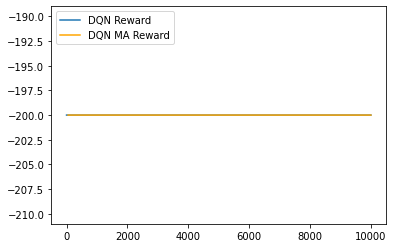

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

data = {'Reward':  stats.episode_rewards}
df = pd.DataFrame (data)

rolling_mean = df.Reward.rolling(window=50).mean()

plt.plot(df.index, df.Reward, label='DQN Reward')
plt.plot(df.index, rolling_mean, label='DQN MA Reward', color='orange')
plt.legend(loc='upper left')
plt.show()
df.to_csv('output_DQN_mountain.csv', index=False)  